시계열 문제지만,

분류 모델로 돌려봄

In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('../edited_debt.csv')
# df = pd.read_csv('../edited.csv')

y = df['Y'].apply(lambda x: 0 if x=='leave' else 1)
# X = df[['FFRm', 'CPI', 'KBR', 'debt']]
X = df[['FFRm', 'CPI', 'debt']]

In [3]:
from sklearn.model_selection import train_test_split

X_train, self_test_x = train_test_split(X, test_size = .2, random_state=3)
y_train, self_test_y = train_test_split(y, test_size = .2, random_state=3)

In [4]:
len(X_train), len(self_test_x)

(177, 45)

---

### RandomForest

In [5]:
from sklearn.ensemble import *
from sklearn.metrics import *
from sklearn.model_selection import *

model = RandomForestClassifier(max_depth=2, n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
target_names=['leave', 'change']

print("Confusion Matrix:\n\n",confusion_matrix(y_train, y_pred), "\n")
print("Classification report:\n\n",classification_report(y_train, y_pred, target_names=target_names))

Confusion Matrix:

 [[147   0]
 [ 28   2]] 

Classification report:

              precision    recall  f1-score   support

      leave       0.84      1.00      0.91       147
     change       1.00      0.07      0.12        30

avg / total       0.87      0.84      0.78       177



In [6]:
model = RandomForestClassifier(max_depth=10, n_estimators=100, n_jobs=-1)
model.fit(X_train, y_train)

y_pred = model.predict(X_train)
target_names=['leave', 'change']

print("Confusion Matrix:\n\n",confusion_matrix(y_train, y_pred), "\n")
print("Classification report:\n\n",classification_report(y_train, y_pred, target_names=target_names))

Confusion Matrix:

 [[147   0]
 [  2  28]] 

Classification report:

              precision    recall  f1-score   support

      leave       0.99      1.00      0.99       147
     change       1.00      0.93      0.97        30

avg / total       0.99      0.99      0.99       177



In [7]:
cv = KFold(2)
print("Cross Validation")
print("accuracy:",cross_val_score(model, self_test_x, self_test_y, scoring="accuracy", cv=cv).mean())
print("recall:",cross_val_score(model, self_test_x, self_test_y, scoring="recall", cv=cv).mean())
print("roc_auc:",cross_val_score(model, self_test_x, self_test_y, scoring="roc_auc", cv=cv).mean())
print("f1:",cross_val_score(model, self_test_x, self_test_y, scoring="f1", cv=cv).mean())

Cross Validation
accuracy: 0.7351778656126482
recall: 0.0
roc_auc: 0.35398391812865493
f1: 0.0


overfitted

### Logistic 

In [8]:
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(class_weight={0:.2, 1:.8}).fit(X_train, y_train)

y_pred = model.predict(X_train)
print("Confusion Matrix:\n\n",confusion_matrix(y_train, y_pred), "\n")
print("Classification report:\n\n",classification_report(y_train, y_pred, target_names=target_names))

Confusion Matrix:

 [[105  42]
 [ 16  14]] 

Classification report:

              precision    recall  f1-score   support

      leave       0.87      0.71      0.78       147
     change       0.25      0.47      0.33        30

avg / total       0.76      0.67      0.71       177



In [9]:
print("Cross Validation")
print("accuracy:",cross_val_score(model, self_test_x, self_test_y, scoring="accuracy", cv=cv).mean())
print("recall:",cross_val_score(model, self_test_x, self_test_y, scoring="recall", cv=cv).mean())
print("roc_auc:",cross_val_score(model, self_test_x, self_test_y, scoring="roc_auc", cv=cv).mean())
print("f1:",cross_val_score(model, self_test_x, self_test_y, scoring="f1", cv=cv).mean())

Cross Validation
accuracy: 0.6007905138339921
recall: 0.625
roc_auc: 0.6571637426900585
f1: 0.35416666666666663


---

### Boosting

In [10]:
import lightgbm as lgb

X_train, self_test_x = train_test_split(X, test_size = .25, random_state=333)
y_train, self_test_y = train_test_split(y, test_size = .25, random_state=333)

X_train, X_test = train_test_split(X_train, test_size = .25, random_state=333)
y_train, y_test = train_test_split(y_train, test_size = .25, random_state=333)

train_data = lgb.Dataset(X_train, label=y_train)

test_data = lgb.Dataset(X_test, label=y_test)

self_test_data = lgb.Dataset(self_test_x, label=self_test_y)

In [11]:
param = {'objective': 'multiclass',  'num_class': 2, 
              'num_leaves':10, 'max_depth': -1,
              'boosting':'gbdt',
         'bagging_fraction': 0.8, 'bagging_freq': 3, 
                }
param['metric'] = 'auc'
param

{'bagging_fraction': 0.8,
 'bagging_freq': 3,
 'boosting': 'gbdt',
 'max_depth': -1,
 'metric': 'auc',
 'num_class': 2,
 'num_leaves': 10,
 'objective': 'multiclass'}

In [12]:
num_round = 50
bst = lgb.train(param, train_data, num_round, valid_sets=[test_data], early_stopping_rounds=10)

[1]	valid_0's auc: 0.526531
Training until validation scores don't improve for 10 rounds.
[2]	valid_0's auc: 0.328571
[3]	valid_0's auc: 0.369388
[4]	valid_0's auc: 0.385714
[5]	valid_0's auc: 0.430612
[6]	valid_0's auc: 0.504082
[7]	valid_0's auc: 0.497959
[8]	valid_0's auc: 0.506122
[9]	valid_0's auc: 0.514286
[10]	valid_0's auc: 0.530612
[11]	valid_0's auc: 0.538776
[12]	valid_0's auc: 0.497959
[13]	valid_0's auc: 0.457143
[14]	valid_0's auc: 0.440816
[15]	valid_0's auc: 0.428571
[16]	valid_0's auc: 0.379592
[17]	valid_0's auc: 0.369388
[18]	valid_0's auc: 0.402041
[19]	valid_0's auc: 0.414286
[20]	valid_0's auc: 0.406122
[21]	valid_0's auc: 0.381633
Early stopping, best iteration is:
[11]	valid_0's auc: 0.538776


In [13]:
lgb.cv(param, self_test_data, 5, nfold=3)

{'auc-mean': [0.5, 0.5, 0.5, 0.5, 0.5], 'auc-stdv': [0.0, 0.0, 0.0, 0.0, 0.0]}

Plot feature importances...


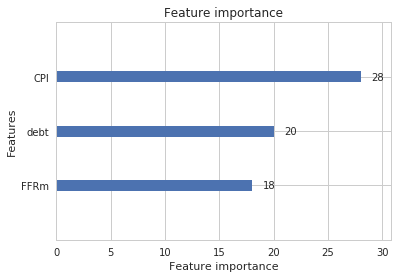

In [14]:
%matplotlib inline
print('Plot feature importances...')
ax = lgb.plot_importance(bst, max_num_features=3)
plt.show()